In [1]:
from __future__ import division

import torch
from torch.utils.data import Dataset
from torchvision.transforms import Normalize
import numpy as np
import cv2
from os.path import join

import config
import constants
from utils.imutils import crop, flip_img, flip_pose, flip_kp, transform, rot_aa

class BaseDataset(Dataset):
    """
    Base Dataset Class - Handles data loading and augmentation.
    Able to handle heterogeneous datasets (different annotations available for different datasets).
    You need to update the path to each dataset in utils/config.py.
    """

    def __init__(self, options, dataset, ignore_3d=False, use_augmentation=True, is_train=True):
        super(BaseDataset, self).__init__()
        self.dataset = dataset
        self.is_train = is_train
        self.options = options
        self.img_dir = config.DATASET_FOLDERS[dataset]
        self.normalize_img = Normalize(mean=constants.IMG_NORM_MEAN, std=constants.IMG_NORM_STD)
        self.data = np.load(config.DATASET_FILES[is_train][dataset])
        self.imgname = self.data['imgname']
        
        # Get paths to gt masks, if available
        try:
            self.maskname = self.data['maskname']
        except KeyError:
            pass
        try:
            self.partname = self.data['partname']
        except KeyError:
            pass

        # Bounding boxes are assumed to be in the center and scale format
        self.scale = self.data['scale']
        self.center = self.data['center']
        
        # If False, do not do augmentation
        self.use_augmentation = use_augmentation
        
        # Get gt SMPL parameters, if available
        try:
            self.pose = self.data['pose'].astype(np.float)
            self.betas = self.data['shape'].astype(np.float)
            if 'has_smpl' in self.data:
                self.has_smpl = self.data['has_smpl']
            else:
                self.has_smpl = np.ones(len(self.imgname))
        except KeyError:
            self.has_smpl = np.zeros(len(self.imgname))
        if ignore_3d:
            self.has_smpl = np.zeros(len(self.imgname))
        
        # Get gt 3D pose, if available
        try:
            self.pose_3d = self.data['S']
            self.has_pose_3d = 1
        except KeyError:
            self.has_pose_3d = 0
        if ignore_3d:
            self.has_pose_3d = 0
        
        # Get 2D keypoints
        try:
            keypoints_gt = self.data['part']
        except KeyError:
            keypoints_gt = np.zeros((len(self.imgname), 24, 3))
        try:
            keypoints_openpose = self.data['openpose']
        except KeyError:
            keypoints_openpose = np.zeros((len(self.imgname), 25, 3))
        self.keypoints = np.concatenate([keypoints_openpose, keypoints_gt], axis=1)

        # Get gender data, if available
        try:
            gender = self.data['gender']
            self.gender = np.array([0 if str(g) == 'm' else 1 for g in gender]).astype(np.int32)
        except KeyError:
            self.gender = -1*np.ones(len(self.imgname)).astype(np.int32)
        
        self.length = self.scale.shape[0]

    def augm_params(self):
        """Get augmentation parameters."""
        flip = 0            # flipping
        pn = np.ones(3)  # per channel pixel-noise
        rot = 0            # rotation
        sc = 1            # scaling
        if self.is_train:
            # We flip with probability 1/2
            if np.random.uniform() <= 0.5:
                flip = 1
            
            # Each channel is multiplied with a number 
            # in the area [1-opt.noiseFactor,1+opt.noiseFactor]
            pn = np.random.uniform(1-self.options.noise_factor, 1+self.options.noise_factor, 3)
            
            # The rotation is a number in the area [-2*rotFactor, 2*rotFactor]
            rot = min(2*self.options.rot_factor,
                    max(-2*self.options.rot_factor, np.random.randn()*self.options.rot_factor))
            
            # The scale is multiplied with a number
            # in the area [1-scaleFactor,1+scaleFactor]
            sc = min(1+self.options.scale_factor,
                    max(1-self.options.scale_factor, np.random.randn()*self.options.scale_factor+1))
            # but it is zero with probability 3/5
            if np.random.uniform() <= 0.6:
                rot = 0
        
        return flip, pn, rot, sc

    def rgb_processing(self, rgb_img, center, scale, rot, flip, pn):
        """Process rgb image and do augmentation."""
        rgb_img = crop(rgb_img, center, scale, 
                      [constants.IMG_RES, constants.IMG_RES], rot=rot)
        # flip the image 
        if flip:
            rgb_img = flip_img(rgb_img)
        # in the rgb image we add pixel noise in a channel-wise manner
        rgb_img[:,:,0] = np.minimum(255.0, np.maximum(0.0, rgb_img[:,:,0]*pn[0]))
        rgb_img[:,:,1] = np.minimum(255.0, np.maximum(0.0, rgb_img[:,:,1]*pn[1]))
        rgb_img[:,:,2] = np.minimum(255.0, np.maximum(0.0, rgb_img[:,:,2]*pn[2]))
        # (3,224,224),float,[0,1]
        rgb_img = np.transpose(rgb_img.astype('float32'),(2,0,1))/255.0
        return rgb_img

    def j2d_processing(self, kp, center, scale, r, f):
        """Process gt 2D keypoints and apply all augmentation transforms."""
        nparts = kp.shape[0]
        for i in range(nparts):
            kp[i,0:2] = transform(kp[i,0:2]+1, center, scale, 
                                  [constants.IMG_RES, constants.IMG_RES], rot=r)
        # convert to normalized coordinates
        kp[:,:-1] = 2.*kp[:,:-1]/constants.IMG_RES - 1.
        # flip the x coordinates
        if f:
             kp = flip_kp(kp)
        kp = kp.astype('float32')
        return kp

    def j3d_processing(self, S, r, f):
        """Process gt 3D keypoints and apply all augmentation transforms."""
        # in-plane rotation
        rot_mat = np.eye(3)
        if not r == 0:
            rot_rad = -r * np.pi / 180
            sn,cs = np.sin(rot_rad), np.cos(rot_rad)
            rot_mat[0,:2] = [cs, -sn]
            rot_mat[1,:2] = [sn, cs]
        S[:, :-1] = np.einsum('ij,kj->ki', rot_mat, S[:, :-1]) 
        # flip the x coordinates
        if f:
            S = flip_kp(S)
        S = S.astype('float32')
        return S

    def pose_processing(self, pose, r, f):
        """Process SMPL theta parameters  and apply all augmentation transforms."""
        # rotation or the pose parameters
        pose[:3] = rot_aa(pose[:3], r)
        # flip the pose parameters
        if f:
            pose = flip_pose(pose)
        # (72),float
        pose = pose.astype('float32')
        return pose

    def __getitem__(self, index):
        item = {}
        scale = self.scale[index].copy()
        center = self.center[index].copy()

        # Get augmentation parameters
        flip, pn, rot, sc = self.augm_params()
        
        # Load image
        imgname = join(self.img_dir, self.imgname[index])
        try:
            img = cv2.imread(imgname)[:,:,::-1].copy().astype(np.float32)
        except TypeError:
            print(imgname)
        orig_shape = np.array(img.shape)[:2]

        # Get SMPL parameters, if available
        if self.has_smpl[index]:
            pose = self.pose[index].copy()
            betas = self.betas[index].copy()
        else:
            pose = np.zeros(72)
            betas = np.zeros(10)

        # Process image
        img = self.rgb_processing(img, center, sc*scale, rot, flip, pn)
        img = torch.from_numpy(img).float()
        # Store image before normalization to use it in visualization
        item['img'] = self.normalize_img(img)
        item['pose'] = torch.from_numpy(self.pose_processing(pose, rot, flip)).float()
        item['betas'] = torch.from_numpy(betas).float()
        item['imgname'] = imgname

        # Get 3D pose, if available
        if self.has_pose_3d:
            S = self.pose_3d[index].copy()
            item['pose_3d'] = torch.from_numpy(self.j3d_processing(S, rot, flip)).float()
        else:
            item['pose_3d'] = torch.zeros(24,4, dtype=torch.float32)

        # Get 2D keypoints and apply augmentation transforms
        keypoints = self.keypoints[index].copy()
        item['keypoints'] = torch.from_numpy(self.j2d_processing(keypoints, center, sc*scale, rot, flip)).float()

        item['has_smpl'] = self.has_smpl[index]
        item['has_pose_3d'] = self.has_pose_3d
        item['scale'] = float(sc * scale)
        item['center'] = center.astype(np.float32)
        item['orig_shape'] = orig_shape
        item['is_flipped'] = flip
        item['rot_angle'] = np.float32(rot)
        item['gender'] = self.gender[index]
        item['sample_index'] = index
        item['dataset_name'] = self.dataset

        try:
            item['maskname'] = self.maskname[index]
        except AttributeError:
            item['maskname'] = ''
        try:
            item['partname'] = self.partname[index]
        except AttributeError:
            item['partname'] = ''

        return item

    def __len__(self):
        return len(self.imgname)

In [23]:
class Options:
    pass

options = Options()

options.noise_factor = 0.4
options.scale_factor = 0.25
options.rot_factor = 30

total_capture = BaseDataset(options, 'total-capture')

len(total_capture)

28144

In [8]:
total_capture[0]['img'].shape

torch.Size([3, 224, 224])

In [9]:
ds_3dpw = BaseDataset(options, '3dpw')

In [14]:
ds_3dpw[0]['img'].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


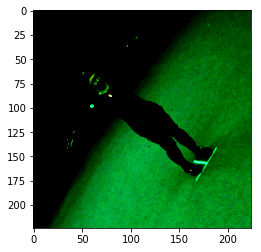

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

img_t = total_capture[0]['img']

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


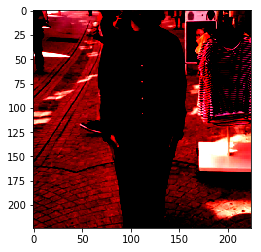

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

img_t = ds_3dpw[0]['img']

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [19]:
"""
This file contains the definition of different heterogeneous datasets used for training
"""
import torch
import numpy as np

#from .base_dataset import BaseDataset

class MixedDataset(torch.utils.data.Dataset):

    def __init__(self, options, **kwargs):
        #self.dataset_list = ['h36m', 'lsp-orig', 'mpii', 'lspet', 'coco', 'mpi-inf-3dhp']
        self.dataset_list = ['total-capture']
        #self.dataset_dict = {'h36m': 0, 'lsp-orig': 1, 'mpii': 2, 'lspet': 3, 'coco': 4, 'mpi-inf-3dhp': 5}
        self.dataset_dict = {'total-capture': 0}
        
        self.datasets = [BaseDataset(options, ds, **kwargs) for ds in self.dataset_list]
        total_length = sum([len(ds) for ds in self.datasets])
        length_itw = sum([len(ds) for ds in self.datasets[1:-1]])
        self.length = max([len(ds) for ds in self.datasets])
        
        """
        Data distribution inside each batch:
        30% H36M - 60% ITW - 10% MPI-INF
        """
        self.partition = [1]
        self.partition = np.array(self.partition).cumsum()
        print(self.partition)

    def __getitem__(self, index):
        p = np.random.rand()
        for i in range(1): # Change range 6 to 2, since only two datasets will be used
            if p <= self.partition[i]:
                return self.datasets[i][index % len(self.datasets[i])]

    def __len__(self):
        return self.length

In [20]:
total_capture_mixed = MixedDataset(options)

[1]


In [47]:
import constants
from utils.imutils import crop, flip_img, flip_pose, flip_kp, transform, rot_aa

def rgb_processing(rgb_img, center, scale, rot, flip, pn):
        """Process rgb image and do augmentation."""
        rgb_img = crop(rgb_img, center, scale, 
                      [constants.IMG_RES, constants.IMG_RES], rot=rot)
        # flip the image 
        if flip:
            rgb_img = flip_img(rgb_img)
        # in the rgb image we add pixel noise in a channel-wise manner
        rgb_img[:,:,0] = np.minimum(255.0, np.maximum(0.0, rgb_img[:,:,0]*pn[0]))
        rgb_img[:,:,1] = np.minimum(255.0, np.maximum(0.0, rgb_img[:,:,1]*pn[1]))
        rgb_img[:,:,2] = np.minimum(255.0, np.maximum(0.0, rgb_img[:,:,2]*pn[2]))
        # (3,224,224),float,[0,1]
        rgb_img = np.transpose(rgb_img.astype('float32'),(2,0,1))/255.0
        return rgb_img

In [48]:
import config
import numpy as np
import os

dataset = 'total-capture'

img_dir = config.DATASET_FOLDERS[dataset]

npz_file = np.load('data/dataset_extras/total_capture_train.npz')

imgname = os.path.join(img_dir, npz_file['imgname'][0])

In [49]:
img = cv2.imread(imgname)[:,:,::-1].copy().astype(np.float32)

In [50]:
img.shape

(1080, 1920, 3)

In [52]:
center = npz_file['center'][0]
scale = npz_file['scale'][0]

flip = 0
pn = np.ones(3)
rot = 0
sc = 1


img = rgb_processing(img, center, sc*scale, rot, flip, pn)

In [53]:
img

array([[[0.16078432, 0.15294118, 0.14901961, ..., 0.11764706,
         0.12156863, 0.11764706],
        [0.16470589, 0.15686275, 0.15686275, ..., 0.11764706,
         0.11764706, 0.1254902 ],
        [0.17254902, 0.16470589, 0.15686275, ..., 0.11764706,
         0.12156863, 0.12156863],
        ...,
        [0.54509807, 0.5411765 , 0.5411765 , ..., 0.5019608 ,
         0.49803922, 0.49803922],
        [0.54509807, 0.5372549 , 0.53333336, ..., 0.4862745 ,
         0.4862745 , 0.4862745 ],
        [0.5411765 , 0.5411765 , 0.54509807, ..., 0.49019608,
         0.4862745 , 0.47843137]],

       [[0.23921569, 0.23921569, 0.23529412, ..., 0.19215687,
         0.2       , 0.19607843],
        [0.24313726, 0.24313726, 0.23921569, ..., 0.19215687,
         0.19215687, 0.19607843],
        [0.24313726, 0.24313726, 0.23921569, ..., 0.19215687,
         0.19607843, 0.19607843],
        ...,
        [0.5019608 , 0.5019608 , 0.5019608 , ..., 0.45882353,
         0.45490196, 0.45490196],
        [0.5

In [1]:
import numpy as np

npz = np.load('data/dataset_extras/total_capture_train.npz')

In [3]:
len(npz['imgname'])

28144

In [4]:
npz['imgname'][0]

's_02_act_02_subact_01_ca_01/000000.jpg'

In [5]:
npz['imgname'][20000]

's_02_act_02_subact_01_ca_06/002410.jpg'

In [6]:
npz['imgname'][28000]

's_02_act_02_subact_01_ca_08/003374.jpg'

In [8]:
import cv2

imgname = '../Datasets/TotalCapture-Toolbox/data/images/s_02_act_02_subact_01_ca_01/002342.jpg'

img = cv2.imread(imgname)[:,:,::-1].copy().astype(np.float32)

TypeError: 'NoneType' object is not subscriptable

In [3]:
import config
import numpy as np
import os
import cv2

dataset = 'total-capture'

img_dir = config.DATASET_FOLDERS[dataset]

npz_file = np.load('data/dataset_extras/total_capture_train.npz')

imgname = os.path.join(img_dir, npz_file['imgname'][0])

In [4]:
img = cv2.imread(imgname)[:,:,::-1].copy().astype(np.float32)

TypeError: 'NoneType' object is not subscriptable